In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchview import draw_graph
import os

from common import h5dataset, onnxexporter, model_dnn, trainer


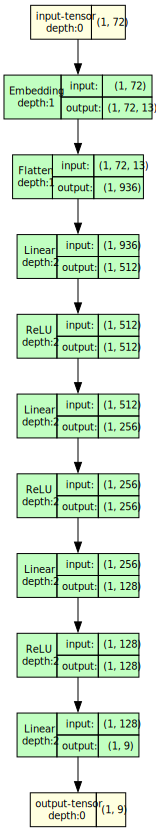

In [2]:
# Plot model graph
model = model_dnn.ModelDNN(
    name="Jass",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model_graph = draw_graph(model, torch.zeros(1, 72).long(), show_shapes=True)
model_graph.visual_graph

In [3]:
DATASET_PATH = '../log_parser/dataset/flat_playing.hdf5'
if not os.path.exists(DATASET_PATH):
    raise FileNotFoundError(f"Dataset not found at {DATASET_PATH}")

MODLE_PATH = './models/play'
if not os.path.exists(MODLE_PATH):
    os.makedirs(MODLE_PATH)

LOGS_PATH = './logs/play'
if not os.path.exists(LOGS_PATH):
    os.makedirs(LOGS_PATH)

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS = 20
LEARNING_RATE = 1e-3
SEED = 42

torch.manual_seed(SEED)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load dataset
dataset = h5dataset.H5Dataset(DATASET_PATH)
train_dataset, val_dataset = dataset.split(0.8)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8)

model_sizes = [
    [256, 128],
    [512, 256],
    [1024, 512],
    [256, 128, 64],
    [512, 256, 128],
    [1024, 512, 256],
    [256, 128, 64, 32],
    [512, 256, 128, 64],
    [1024, 512, 256, 128]
]

accuracy_fn = lambda y_pred, y_true: (y_pred.argmax(dim=1) == y_true).float().mean()
loss_fn = lambda y_pred, y_true: F.nll_loss(F.log_softmax(y_pred, dim=1), y_true)

# set up trainer
trainer = trainer.Trainer(
    train_loader=train_loader,
    val_loader=val_loader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn,
    model_path=MODLE_PATH,
    device=device
)

Using device: cuda


In [5]:
# train the model
for model_size in model_sizes:
    model = model_dnn.ModelDNN(
        name="JassPlay",
        input_size=72,
        embedding_size=13,
        hidden_size=model_size,
        output_size=9,
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    trainer.train(NUM_EPOCHS, model, optimizer)

Training model: JassPlay_512_256_128_dnn


Validation Epoch 1: 100%|██████████| 17333/17333 [01:04<00:00, 269.45it/s]


Epoch 1/20 - Train Loss: 0.7438, Train Accuracy: 68.7844, Val Loss: 0.6678, Val Accuracy: 72.2402
Model saved at epoch 1 with validation loss 0.6678


Validation Epoch 2: 100%|██████████| 17333/17333 [01:01<00:00, 279.58it/s]


Epoch 2/20 - Train Loss: 0.6401, Train Accuracy: 73.5288, Val Loss: 0.6214, Val Accuracy: 74.4625
Model saved at epoch 2 with validation loss 0.6214


Validation Epoch 3: 100%|██████████| 17333/17333 [01:03<00:00, 274.99it/s]


Epoch 3/20 - Train Loss: 0.6058, Train Accuracy: 75.1679, Val Loss: 0.5979, Val Accuracy: 75.4819
Model saved at epoch 3 with validation loss 0.5979


Validation Epoch 4: 100%|██████████| 17333/17333 [01:03<00:00, 272.72it/s]


Epoch 4/20 - Train Loss: 0.5883, Train Accuracy: 75.9504, Val Loss: 0.5854, Val Accuracy: 76.1088
Model saved at epoch 4 with validation loss 0.5854


Validation Epoch 5: 100%|██████████| 17333/17333 [01:03<00:00, 274.50it/s]


Epoch 5/20 - Train Loss: 0.5774, Train Accuracy: 76.4289, Val Loss: 0.5790, Val Accuracy: 76.3489
Model saved at epoch 5 with validation loss 0.5790


Validation Epoch 6: 100%|██████████| 17333/17333 [01:02<00:00, 276.51it/s]


Epoch 6/20 - Train Loss: 0.5705, Train Accuracy: 76.7481, Val Loss: 0.5723, Val Accuracy: 76.6555
Model saved at epoch 6 with validation loss 0.5723


Validation Epoch 7: 100%|██████████| 17333/17333 [01:03<00:00, 274.96it/s]


Epoch 7/20 - Train Loss: 0.5655, Train Accuracy: 76.9794, Val Loss: 0.5691, Val Accuracy: 76.8443
Model saved at epoch 7 with validation loss 0.5691


Validation Epoch 8: 100%|██████████| 17333/17333 [01:03<00:00, 273.77it/s]


Epoch 8/20 - Train Loss: 0.5620, Train Accuracy: 77.1527, Val Loss: 0.5649, Val Accuracy: 77.0111
Model saved at epoch 8 with validation loss 0.5649


Validation Epoch 9: 100%|██████████| 17333/17333 [01:04<00:00, 270.11it/s]


Epoch 9/20 - Train Loss: 0.5593, Train Accuracy: 77.2736, Val Loss: 0.5628, Val Accuracy: 77.1169
Model saved at epoch 9 with validation loss 0.5628


Validation Epoch 10: 100%|██████████| 17333/17333 [01:02<00:00, 277.95it/s]


Epoch 10/20 - Train Loss: 0.5571, Train Accuracy: 77.3843, Val Loss: 0.5618, Val Accuracy: 77.2127
Model saved at epoch 10 with validation loss 0.5618


Validation Epoch 11: 100%|██████████| 17333/17333 [01:03<00:00, 274.83it/s]


Epoch 11/20 - Train Loss: 0.5554, Train Accuracy: 77.4733, Val Loss: 0.5640, Val Accuracy: 77.1534


Validation Epoch 12: 100%|██████████| 17333/17333 [01:02<00:00, 275.50it/s]


Epoch 12/20 - Train Loss: 0.5540, Train Accuracy: 77.5309, Val Loss: 0.5593, Val Accuracy: 77.3138
Model saved at epoch 12 with validation loss 0.5593


Validation Epoch 13: 100%|██████████| 17333/17333 [01:03<00:00, 273.77it/s]


Epoch 13/20 - Train Loss: 0.5528, Train Accuracy: 77.5986, Val Loss: 0.5592, Val Accuracy: 77.3512
Model saved at epoch 13 with validation loss 0.5592


Validation Epoch 14: 100%|██████████| 17333/17333 [01:03<00:00, 272.83it/s]


Epoch 14/20 - Train Loss: 0.5518, Train Accuracy: 77.6342, Val Loss: 0.5615, Val Accuracy: 77.2553


Validation Epoch 15: 100%|██████████| 17333/17333 [01:04<00:00, 270.08it/s]


Epoch 15/20 - Train Loss: 0.5510, Train Accuracy: 77.6802, Val Loss: 0.5597, Val Accuracy: 77.3629


Validation Epoch 16: 100%|██████████| 17333/17333 [01:03<00:00, 272.34it/s]


Epoch 16/20 - Train Loss: 0.5503, Train Accuracy: 77.7212, Val Loss: 0.5577, Val Accuracy: 77.4009
Model saved at epoch 16 with validation loss 0.5577


Validation Epoch 17: 100%|██████████| 17333/17333 [01:04<00:00, 270.50it/s]

Epoch 17/20 - Train Loss: 0.5498, Train Accuracy: 77.7481, Val Loss: 0.5605, Val Accuracy: 77.3786


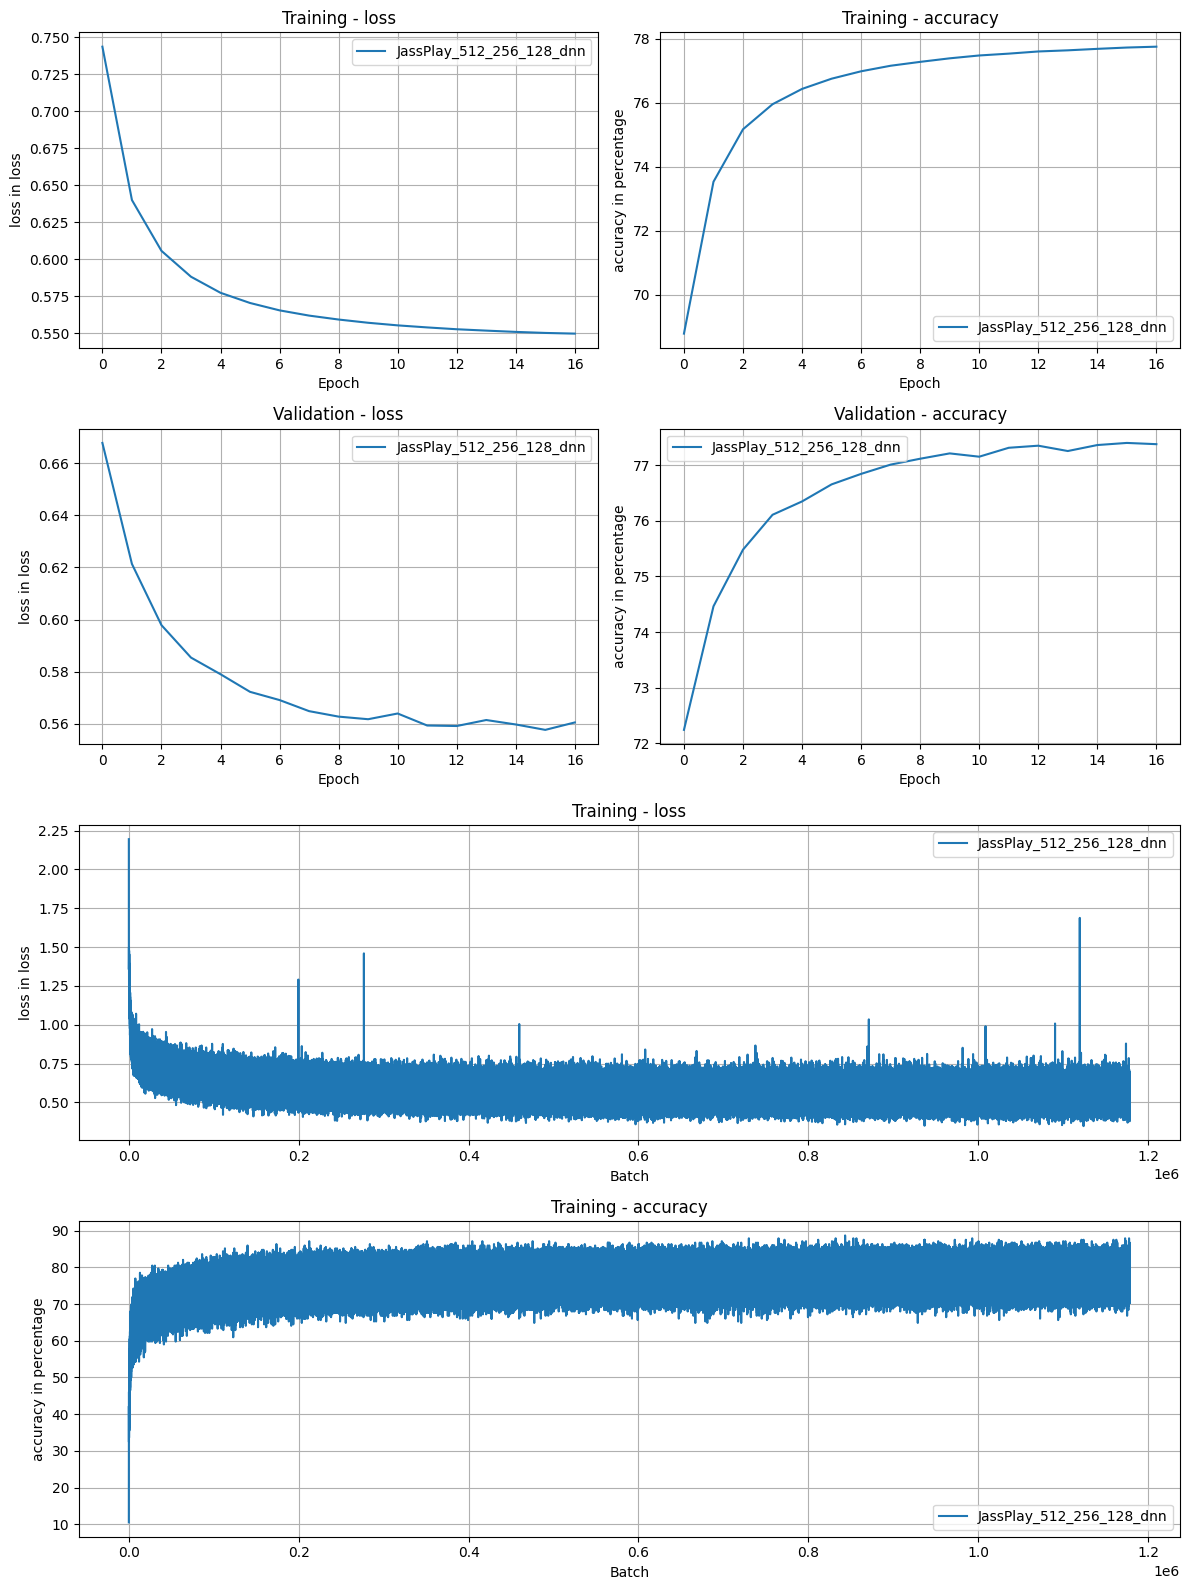

In [6]:
# create graphs
trainer.monitor.plot()

In [7]:
trainer.monitor.dump(dump_path=LOGS_PATH, filename="monitor")

In [8]:
# export the model to ONNX
ONNX_PATH = f"{MODLE_PATH}/{model.name}.onnx"
model = model_dnn.ModelDNN(
    name="JassPlay",
    input_size=72,
    embedding_size=13,
    hidden_size=[512, 256, 128],
    output_size=9,
)
model.load_state_dict(torch.load(f"{MODLE_PATH}/{model.name}.pth"))
onnxexporter.onnx_exporter(
    model=model,
    in_dim=72,
    output_path=ONNX_PATH
)

Exporting model to ONNX format...
Successfully converted and saved ONNX model to ./models/play/JassPlay_512_256_128_dnn.onnx
